<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
# !pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

<AxesSubplot:>

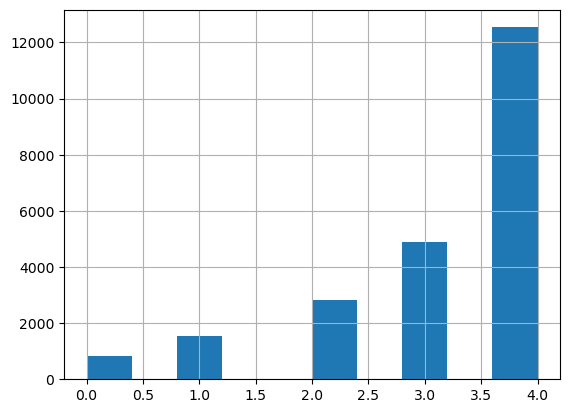

In [7]:
df_reviews['Rating'].hist()

In [8]:
map_rating={0:1, 1:1, 2:1, 3:2, 3:2, 4:3}

In [9]:
df_reviews['new_rating'] = df_reviews['Rating'].map(lambda x: map_rating.get(x))

In [10]:
df_reviews['new_rating'].value_counts()

3    12540
1     5193
2     4908
Name: new_rating, dtype: int64

<AxesSubplot:>

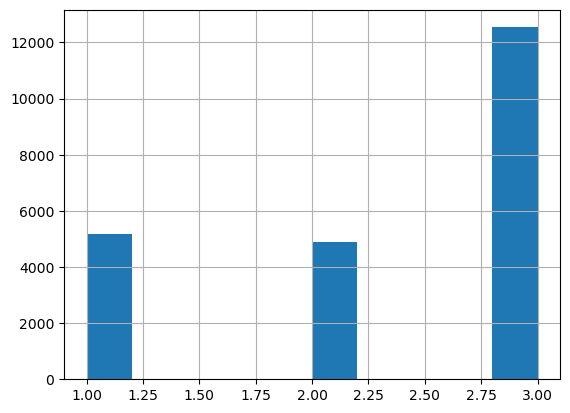

In [11]:
df_reviews['new_rating'].hist()

In [12]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

In [13]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = df_reviews['Review Text'].values

In [14]:
reviews[:5]

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothi

In [15]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
reviews.size

22641

In [16]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews)

In [17]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [18]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

In [19]:
tokens = text_to_word_sequence(corpus)

In [20]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [21]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [22]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 3000
vocab_size = num_words

In [23]:
tok = Tokenizer(num_words=num_words) 
tok.fit_on_texts(tokens)

In [24]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [25]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(reviews)

In [26]:
sequences[0][:10]

[253, 532, 917, 3, 662, 3, 68]

In [27]:
# Alumno: Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 115


(array([ 801., 2149., 2710., 3102., 2669., 2392., 2214., 2713., 3494.,
         397.]),
 array([  2. ,  13.3,  24.6,  35.9,  47.2,  58.5,  69.8,  81.1,  92.4,
        103.7, 115. ]),
 <BarContainer object of 10 artists>)

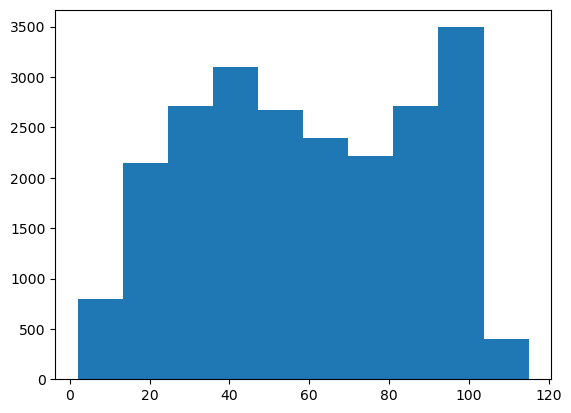

In [28]:
plt.hist(x=seqs_lenght)

In [29]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 100

In [30]:
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [31]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 100)

In [32]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(df_reviews['Rating'].to_numpy().reshape(-1,1))
y[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [33]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 100 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [35]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [36]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_length=in_shape))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2023-06-01 19:41:05.603384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          300100    
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8

In [37]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [38]:
hist = model.fit(X_train, y_train_encoded, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 76s 160ms/step - loss: 1.0718 - accuracy: 0.5836 - val_loss: 0.9571 - val_accuracy: 0.6141
Epoch 2/20
453/453 [==============================] - 84s 185ms/step - loss: 0.8816 - accuracy: 0.6241 - val_loss: 0.9472 - val_accuracy: 0.6202
Epoch 3/20
453/453 [==============================] - 83s 182ms/step - loss: 0.8192 - accuracy: 0.6506 - val_loss: 0.9146 - val_accuracy: 0.6241
Epoch 4/20
453/453 [==============================] - 81s 180ms/step - loss: 0.7518 - accuracy: 0.6790 - val_loss: 0.9373 - val_accuracy: 0.6221
Epoch 5/20
453/453 [==============================] - 85s 187ms/step - loss: 0.6933 - accuracy: 0.7062 - val_loss: 0.9801 - val_accuracy: 0.6161
Epoch 6/20
453/453 [==============================] - 83s 184ms/step - loss: 0.6491 - accuracy: 0.7326 - val_loss: 1.0492 - val_accuracy: 0.6128
Epoch 7/20
453/453 [==============================] - 81s 178ms/step - loss: 0.6107 - accuracy: 0.7502 - val_loss: 1.0929 - val_ac

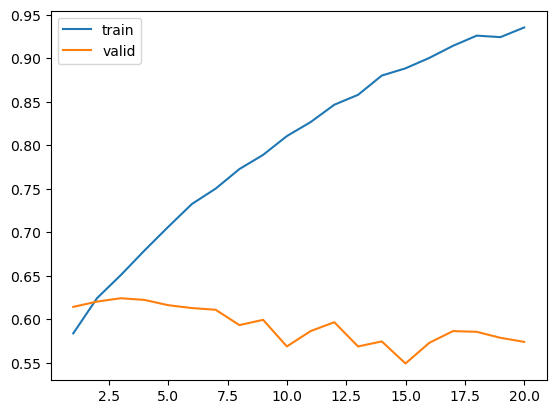

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [40]:
y_pred_one_hot_encoded  = (model.predict(X_test)> 0.5).astype("int32")

142/142 [==============================] - 8s 49ms/step


In [41]:
y_pred = np.array(tf.argmax(y_pred_one_hot_encoded , axis=1))

In [42]:
y_test = np.array(tf.argmax(y_test_encoded , axis=1))

In [43]:
from sklearn.metrics import confusion_matrix, f1_score
confusion_matrix(y_test, y_pred)

array([[  30,   51,   43,   15,    9],
       [  50,   99,   94,   44,   22],
       [  51,  125,  215,  131,   66],
       [  28,   51,  154,  291,  415],
       [  17,   30,   86,  372, 2040]])

In [44]:
f1_score(y_test, y_pred, average='macro')

0.39451679533551515

In [45]:
model.evaluate(X_test, y_test_encoded)

142/142 [==============================] - 8s 55ms/step - loss: 1.8845 - accuracy: 0.5931


[1.8845032453536987, 0.593066930770874]

# Model 2

In [46]:
y = ohe.fit_transform(df_reviews['new_rating'].to_numpy().reshape(-1,1))
y[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [47]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 3 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 100 , out_shape 3


In [49]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model2.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_length=in_shape))
model2.add(LSTM(units=128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          300100    
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          117248    
                                                                 
 dropout_3 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 64)           49408     
                                                                 
 dropout_4 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)              

In [50]:
hist = model2.fit(X_train, y_train_encoded, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 91s 190ms/step - loss: 0.7676 - accuracy: 0.6688 - val_loss: 0.7157 - val_accuracy: 0.7014
Epoch 2/20
453/453 [==============================] - 84s 185ms/step - loss: 0.6434 - accuracy: 0.7224 - val_loss: 0.6787 - val_accuracy: 0.7094
Epoch 3/20
453/453 [==============================] - 84s 186ms/step - loss: 0.5923 - accuracy: 0.7450 - val_loss: 0.7082 - val_accuracy: 0.7190
Epoch 4/20
453/453 [==============================] - 82s 180ms/step - loss: 0.5384 - accuracy: 0.7682 - val_loss: 0.7492 - val_accuracy: 0.7066
Epoch 5/20
453/453 [==============================] - 83s 184ms/step - loss: 0.4974 - accuracy: 0.7909 - val_loss: 0.7401 - val_accuracy: 0.6931
Epoch 6/20
453/453 [==============================] - 85s 188ms/step - loss: 0.4404 - accuracy: 0.8223 - val_loss: 0.8345 - val_accuracy: 0.6638
Epoch 7/20
453/453 [==============================] - 84s 185ms/step - loss: 0.4074 - accuracy: 0.8345 - val_loss: 0.8483 - val_ac

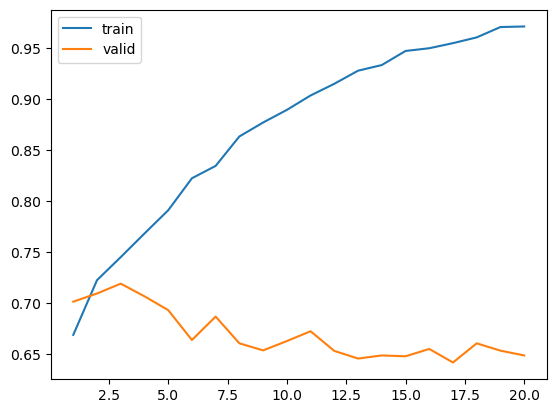

In [51]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [52]:
y_pred_one_hot_encoded  = (model2.predict(X_test)> 0.5).astype("int32")

142/142 [==============================] - 7s 41ms/step


In [53]:
y_pred = np.array(tf.argmax(y_pred_one_hot_encoded , axis=1))

In [54]:
y_test = np.array(tf.argmax(y_test_encoded , axis=1))

In [55]:
confusion_matrix(y_test, y_pred)

array([[ 675,  242,  128],
       [ 187,  339,  413],
       [ 118,  451, 1976]])

In [56]:
f1_score(y_test, y_pred, average='macro')

0.5971245244909344

In [57]:
model2.evaluate(X_test, y_test_encoded)

142/142 [==============================] - 6s 42ms/step - loss: 1.6769 - accuracy: 0.6600


[1.6768704652786255, 0.6599690914154053]